#CO544 Machine Learning and Data Mining
##Take Home Assignment - E/20
### E/20/420 - WANASINGHE J.K.

# 1. Introduction and Dataset Description

## 1.1 Problem statement and objective

- The Objective of this assignment is to build a supervised machine learning pipeline that predicts whether *an adult's annual income exceeds 50,000 USD* based on demographics and attributes related to work.

- Here, a full pipeline is demonstrated including, data understanding (interpretation), preprocessing, feature engineering (selecting and extracting), training the model and evaluating, improvements, and ensemble learning.

- In this assignment, more focus will be given to concepts, attributes, data quality, evaluation metrics, and basic algorithms such as decision tress, Naive Bayes, KNN, and ensembles (bagging and boosting) as discussed in the lectures and handouts.



## 1.2 Dataset source and domain


- Source: UCI Machine Learning Repository (Adult/Census Income dataset) formulated and released by Barry Becker and Ronny Kohavi in 1996; commonly cited as “Becker & Kohavi (1996), Adult, UCI ML Repository.”

- Data origin: Records are drawn from the 1994 U.S. Census database (Census Bureau's 1994 data extract), which is the underlying source from which the UCI dataset was constructed.

- Domain: Socioeconomic and employment demographics (age, education, occupation, workclass, capital gain/loss, hours per week, marital status, relationship, race, sex, native country, etc.) linked to an income label.

- Target variable: income (binary) indicating whether annual income is >50K or <=50K.

- Use case: A widely used benchmarking dataset for tabular machine learning, suitable for:
>- Handling mixed data types (categorical and numeric).
>- Addressing mild missingness (categorical “?” placeholders in fields like workclass, occupation, native-country).
>- Managing class imbalance (>50K is the minority class).
>- Demonstrating preprocessing pipelines (imputation, encoding, scaling), feature selection/extraction, and comparison of linear, tree-based, instance-based, and ensemble methods (e.g., bagging/boosting).

- Rationale for selection: Meets assignment requirements (≥300 instances and >10 features pre-engineering) as this has 14 (13 + 1) features and 48842 instances, supports clear demonstration of course topics (data cleaning, evaluation metrics beyond accuracy, bias-variance, feature selection/extraction, and ensembles), and offers interpretable insights alongside competitive baselines.

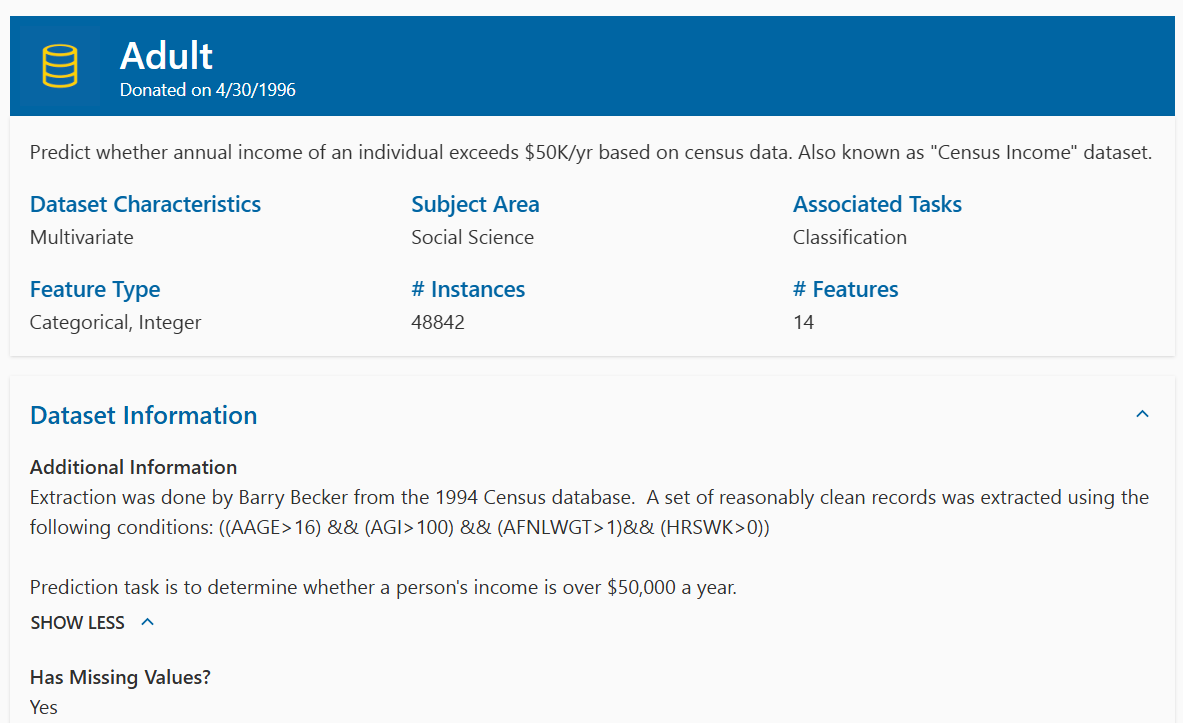

## 1.3 Instances, features, and target

- Number of instances: 48832 > 30,000 records as required
- Number of features: 14 (before preprocessing or feature engineering)
- Target variable:
  - income: binary class label with two categories:
    - “<=50K”
    - “>50K”

- Predictors (as commonly provided in the dataset):
  -  age (integer)
  -  workclass (categorical)
  -  fnlwgt (integer; sampling weight)
  -  education (categorical)
  -  education-num (integer; years of education corresponding to “education”)
  -  marital-status (categorical)
  -  occupation (categorical)
  -  relationship (categorical)
  -  race (categorical)
  -  sex (binary)
  -  capital-gain (integer)
  -  capital-loss (integer)
  -  hours-per-week (integer)
  -  native-country (categorical)

## 1.4 Data characteristics and quality considerations

- Some data is missing: Some categories like workclass, occupation, and native-country have missing information marked with "?". These values are needed to be dealth with
- Not an equal split: More people in the dataset earn <=50K than >50K. This means just looking at overall accuracy isn't enough to know how well our model is doing.Other ways to measure success, like precision, recall, and F1-score will be used here
- Some numbers are lopsided: Some numbers like capital-gain and capital-loss have a lot of zeros and then some very large values. Some adjustment seems required
- Too many categories: Some categories like occupation and native-country have many different options. A technique called one-hot encoding will be used to handle these, making sure to ignore any new categories that might show up later.
- Similar information: The 'education' and 'education-num' columns might be telling us the same thing. We'll figure out if we need to keep both.

## 1.5 Ethical and fairness considerations


The dataset includes sensitive information like sex, race, and where someone was born. While using this information might help predict income better, it could also mean our model reflects or even creates unfair biases that exist in society. Our main focus is on building a good method for prediction, but in our report, we'll talk about how using this information can be a trade-off for fairness. We'll discuss how the model might unfairly impact certain groups and suggest ways to make it fairer in the future, like looking at how well it works for different groups, trying the model without these sensitive features, or deciding not to use certain features based on rules.

# 2. Data Preprocessing

This section describes the end-to-end preprocessing pipeline designed for the Adult Income dataset and explains the reasoning behind each choice so it aligns with the emphasis on data cleaning, integrity, and modeling-readiness.

## 2.1 Goals and guiding principles

- Consistent, model-ready inputs are ensured: Missing values are standardized, categoricals are encoded safely, and numerics are scaled appropriately.
- Leakage is prevented: All transformations are fitted inside cross-validation folds via pipelines.
- Multiple model families are supported: Preprocessing variants suitable for linear/distance-based learners and for tree/ensemble methods are provided.
- Auditability is preserved: A clean, reproducible pipeline is kept with seeded splits and clear ablations.

## 2.2 Load data and initial schema checks

### Why?
- Earlier checks reduce silent schema errors. identify non-standard missingness ("?"), confirm assignment limitations. This reflects "Getting to Know Data" and discrepancy detection guidlines.

In [1]:
import pandas as pd
import numpy as np

# Define column names with reference to the documentation
COLUMNS = [
    "age","workclass","fnlwgt","education","education-num","marital-status",
    "occupation","relationship","race","sex","capital-gain","capital-loss",
    "hours-per-week","native-country","income"
]

# Function to load the Adult dataset from UCI repository
def load_adult_from_uci():
    # URLs for the training and testing datasets
    train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
    test_url  = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

    # Load training data, specifying no header, column names, missing value representation, and skipping initial spaces
    df_tr = pd.read_csv(train_url, header=None, names=COLUMNS, na_values=["?"], skipinitialspace=True)

    # Load testing data, specifying header row, column names, missing value representation, skipping initial spaces, and comment character
    df_te = pd.read_csv(test_url,  header=0,   names=COLUMNS, na_values=["?"], skipinitialspace=True, comment="|")

    # Clean the income column in the test data by removing periods and stripping whitespace
    df_te["income"] = df_te["income"].str.replace(".", "", regex=False).str.strip() # the original test file (adult.test) has a trailing period (".") at the end of the income values (e.g., "<=50K." or ">50K.").

    # Concatenate training and testing dataframes, ignoring original indices
    return pd.concat([df_tr, df_te], ignore_index=True)

# Load the raw data using the defined function
df_raw = load_adult_from_uci()

# Print basic information about the loaded dataframe
print(df_raw.shape) # Print the number of rows and columns
print(df_raw.dtypes) # Print the data types of each column
print(df_raw.head(3)) ## Quick Preview to see parsing worked.

# Calculate and print the number of missing values per column, sorted in descending order
missing_summary = df_raw.isna().sum().sort_values(ascending=False)
print(missing_summary)

(48841, 15)
age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   

       marital-status         occupation   relationship   race   sex  \
0       Never-married       Adm-clerical  Not-in-family  White  Male   
1  Married-civ-spouse    Exec-managerial        Husband  White  Male   
2            Divorced  Handlers-cleaners  Not-in-family  White  Male   

   capital-gain  capital-loss  hours-per-week native-country 

## 2.3 Target Definition and Basic Cleaning

### Why?

-  Making the target binary and explicit, and standardize white space to avoid duplicate catogories. This follows normalization of the inputs before modeling to ensure clean class labels for evaluation.

In [2]:
# Create a copy of the raw DataFrame to avoid modifying the original
df = df_raw.copy()

# Strip leading and trailing whitespace from all string columns
for c in df.columns:
    if df[c].dtype == "object":
        df[c] = df[c].str.strip()

# Create the binary target variable 'y'
# It's 1 if income is ">50K", and 0 otherwise
df["y"] = (df["income"] == ">50K").astype(int)

# Drop the original 'income' column as the binary target 'y' is created
df.drop(columns=["income"], inplace=True)

# Print the count of each class in the target variable 'y'
print(df["y"].value_counts(dropna=False))

y
0    37154
1    11687
Name: count, dtype: int64


## 2.4 Train/validation/test split

### Why?
- Use stratified splitting to address class imbalance, and keep a help-out test set for credible confirmation of validation findings.

In [3]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = df.drop(columns=["y"])
y = df["y"].values

# Perform a 60/20/20 split with stratification to maintain the proportion of the target variable


# First split: 80% for temporary (train+validation), 20% for test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42 # stratify=y ensures the same proportion of target classes in both splits, random state 42 for reproducability
)
# Second split: 25% of X_temp/y_temp for validation (which is 20% of original data), 75% for training (which is 60% of original data)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)  # 0.25 of 0.8 = 0.2

# Print the shapes of the resulting data splits
print(X_train.shape, X_val.shape, X_test.shape)

# Print the proportion of the target variable in the training set to confirm stratification worked
print(pd.Series(y_train).value_counts(normalize=True))

(29304, 14) (9768, 14) (9769, 14)
0    0.760715
1    0.239285
Name: proportion, dtype: float64


## 2.5 Feature Typing and Column Selectors

### Why?
- Distinguishing Numeric and Catogorical columns enables handeling them accordingly
  - Scaling for Numerics
  - Encoding for Categoricals

In [4]:
numeric_cols = [
    "age","fnlwgt","education-num","capital-gain","capital-loss","hours-per-week"
]
categorical_cols = [
    "workclass","education","marital-status","occupation","relationship",
    "race","sex","native-country"
]

for c in numeric_cols + categorical_cols:
    assert c in X_train.columns, f"Missing expected column: {c}"

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)

Numeric: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


## 2.6 Dealing with Missing Values

### Why?
- The Adult dataset uses “?” for missingness in several categoricals, mapped to NaN above.
- Stratergies
  - Catogorical : Most Frequent Imputation
  - Numeric : Use Median
  - Tree Based Models : Treat as own level
  - Linear / Distance Based Models : Imputation


In [5]:
from sklearn.impute import SimpleImputer

# Create a SimpleImputer instance to fill missing numerical values with the median
num_imputer = SimpleImputer(strategy="median")

# Create a SimpleImputer instance to fill missing categorical values with the most frequent value
cat_imputer = SimpleImputer(strategy="most_frequent")

In [6]:
# For Tree Based Training

missing_token = "__MISSING__"
# Use a FunctionTransformer or SimpleImputer(fill_value=missing_token, strategy="constant")
# before OneHotEncoder in the categorical branch for tree pipelines.



## 2.7 Encoding Catogorical Variables

### Why?

- One-hot encoding with unknown handeling prevents inference-time failure and leakage, addressing high-cardinal attributes and unseen levels.
- This makes consistency in better preprocessing and silent errors are prevented

In [7]:
from sklearn.preprocessing import OneHotEncoder

# Create a OneHotEncoder instance for categorical features
# handle_unknown="ignore" allows the encoder to handle unseen categories during inference
# sparse=True is the default behavior and the parameter is removed in newer versions
ohe = OneHotEncoder(handle_unknown="ignore")

## 2.8 Scaling numeric variables and transformation of heavy tails

### Why?

- Linear/distance based models and sensitive to scale and skew
- Scaling and log transforms for heavy-tailed modetary variables (capital gain/loss) stabilize optimizing and better at generality (Tree models are less sensitive to this)

In [8]:
from sklearn.preprocessing import FunctionTransformer, RobustScaler
from sklearn.pipeline import Pipeline
import numpy as np

# Define a function to apply log1p transformation to specified columns in a DataFrame
def log1p_cols(df_input, cols):
    df2 = df_input.copy()
    for c in cols:
        # Apply log1p (log(1+x)) transformation and convert to float
        df2[c] = np.log1p(df2[c].astype(float))
    return df2

# Create a FunctionTransformer to apply the log1p_cols function.
# This transformer will be used within a pipeline to apply log transformation
# specifically to the 'capital-gain' and 'capital-loss' columns.
# validate=False is used because FunctionTransformer expects numpy arrays, but our function works with pandas DataFrames for column selection.
log_transformer = FunctionTransformer(
    lambda D: log1p_cols(pd.DataFrame(D, columns=numeric_cols), ["capital-gain","capital-loss"]).values,
    validate=False
)

# Create a preprocessing pipeline for numeric features suitable for linear/distance-based models
# This pipeline includes imputation, log transformation for specific columns, and robust scaling.
num_linear = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")), # Step 1: Impute missing numerical values with the median
    ("log_tail", log_transformer),              # Step 2: Apply log1p transformation to 'capital-gain' and 'capital-loss'
    ("scale", RobustScaler())                   # Step 3: Scale features using RobustScaler, which is less affected by outliers
])

In [9]:
## Tree Models
# For tree models, minimal numeric preprocessing is sufficient
num_tree = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median"))
])


## 2.9 Column-wise preprocessing pipelines

### Why?
 - ColumnTransformer lets assigning the correct preprocessing to each column type (e.g., scale/impute numbers, one-hot encode categoricals), and when used inside cross-validation it learns those steps only from the training fold so information from validation/test never “leaks” into training
- In section 2.8 transfomations were chosen and tried, here they are packaged into a leak-safe. column-aware pipeline that refits inside each CV fold and then on final training set. This will make results correct and reproducible.

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, RobustScaler
import numpy as np

# Define a function to apply log1p transformation to specified columns in a DataFrame
def log1p_cols(df_input, cols):
    df2 = df_input.copy()
    for c in cols:
        df2[c] = np.log1p(df2[c].astype(float))
    return df2

# Create a FunctionTransformer for log transformation of capital-gain and capital-loss
log_transformer = FunctionTransformer(
    lambda D: log1p_cols(pd.DataFrame(D, columns=numeric_cols), ["capital-gain","capital-loss"]).values,
    validate=False
)

# Pipeline for numeric features suitable for linear/distance-based models
num_linear = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("log_tail", log_transformer),
    ("scale", RobustScaler())
])

# Pipeline for numeric features suitable for tree-based models (minimal preprocessing)
num_tree = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median"))
])


# Common pipeline for categorical features (imputation and one-hot encoding)
cat_common = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encode", OneHotEncoder(handle_unknown="ignore")) # Removed sparse=True
])

# Full preprocessing pipeline for linear/distance-based models
preprocess_linear = ColumnTransformer(
    transformers=[
        ("num", num_linear, numeric_cols),
        ("cat", cat_common, categorical_cols),
    ],
    remainder="drop"
)

# Full preprocessing pipeline for tree-based models
preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", num_tree, numeric_cols),
        ("cat", cat_common, categorical_cols),
    ],
    remainder="drop"
)

# Optional: print the configured transformers (for debugging/inspection)
print(preprocess_linear)
print(preprocess_tree)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('log_tail',
                                                  FunctionTransformer(func=<function <lambda> at 0x0000024A2E106C20>)),
                                                 ('scale', RobustScaler())]),
                                 ['age', 'fnlwgt', 'education-num',
                                  'capital-gain', 'capital-loss',
                                  'hours-per-week']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encode',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                      

## 2.10 Baseline data sanity checks after transformation

###Why?
- Verifying shapes and sparsity validates that encoding/scaling behaved as expected before modeling, supporting audits.


In [11]:
X_train_linear = preprocess_linear.fit_transform(X_train)
X_val_linear   = preprocess_linear.transform(X_val)

print("Linear-friendly shapes:", X_train_linear.shape, X_val_linear.shape)
print("Linear-friendly sparse:", hasattr(X_train_linear, "tocoo"))

X_train_tree = preprocess_tree.fit_transform(X_train)
X_val_tree   = preprocess_tree.transform(X_val)

print("Tree-friendly shapes:", X_train_tree.shape, X_val_tree.shape)
print("Tree-friendly sparse:", hasattr(X_train_tree, "tocoo"))


Linear-friendly shapes: (29304, 104) (9768, 104)
Linear-friendly sparse: True
Tree-friendly shapes: (29304, 104) (9768, 104)
Tree-friendly sparse: True


## 2.11 Addressing Class Imbalance

### Why?
- Since “>50K” is the minority, rely on stratification and class-aware metrics; optionally apply class_weight or resampling in model improvements.

In [12]:
# Code cell (no resampling yet; enable later in modeling section)

from collections import Counter
print("Train class distribution:", Counter(y_train))
print("Val class distribution:", Counter(y_val))
print("Test class distribution:", Counter(y_test))


Train class distribution: Counter({0: 22292, 1: 7012})
Val class distribution: Counter({0: 7431, 1: 2337})
Test class distribution: Counter({0: 7431, 1: 2338})


## 2.12 Redundency Handeling

### Why?

- These two features are encoding overlapping information. A simple corelation and ablation plan will inform whether to keep both or remove one alligining with the feature selection

In [13]:
# Quick check on overlap: groupby averages and correlation
ed_map = X_train[["education","education-num"]].copy()
corr = ed_map["education-num"].corr(
    ed_map["education"].astype("category").cat.codes
)
print("Education vs education-num correlation (codes):", corr)

Education vs education-num correlation (codes): 0.3622922722492614


Though the corelation is pretty low, (not a nearly duplicate), Ablation will be done anyways because;
- Different model families values these two forms differently
  - Linear models : Often from a monotonic numeric rank feature
  - Trees capture non-monotonic catogory effects via one-hot

- Provides a defensible report with an attempt observe low-moderate correlation confirming whether both are required.


In [14]:
# Ablations will be done in modeling by dropping one or the other in a variant
ablation_keep_both = (numeric_cols, categorical_cols)
ablation_drop_ednum = ([c for c in numeric_cols if c != "education-num"], categorical_cols)
ablation_drop_edtxt = (numeric_cols, [c for c in categorical_cols if c != "education"])

## 2.13 Final Packaging of the Preprocessing pipelines for downstream models

### Why?
- Providing named, reusable pipelines for each model family keeps experiments consistent and reproducible across CV and held-out testing.

In [15]:
# Expose objects for downstream modeling
PREPROCESS_PIPELINES = {
    "linear_friendly": preprocess_linear,
    "tree_friendly": preprocess_tree
}

SPLITS = {
    "X_train": X_train, "y_train": y_train,
    "X_val":   X_val,   "y_val":   y_val,
    "X_test":  X_test,  "y_test":  y_test
}

ABLATIONS = {
    "keep_both": ablation_keep_both,
    "drop_education_num": ablation_drop_ednum,
    "drop_education_text": ablation_drop_edtxt
}
print("Preprocessing and splits are ready.")


Preprocessing and splits are ready.


# 3. Exploratory Data Analysis: Use basic statistics, distributions, correlations to obtain insights about data

 Documents targets, types, missingness, distributions, outliers, correlations, and target-feature relationships, including concise visualizations and rationale

**Setup and helpers**

- Purpose: centralize imports, plotting style, and a quick utility to show class balance; providing reproducability, readability

In [16]:
## Setups and Helper Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure plots show nicely
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 5)

# Convenience: safe value_counts normalized
def class_balance(y, topn=None):
    vc = y.value_counts(dropna=False, normalize=True).mul(100).round(2)
    return (vc.head(topn) if topn else vc).to_frame("percent")

## 3.1 Data Snap

### Why?
- A first look confirms row/column counts, data-types, and target presence. This emphasizes 'getting to know data'

In [17]:
# Assuming df is the raw dataframe and target is the name of the target column
print("Shape:", df.shape)
display(df.sample(5, random_state=42))
display(df.dtypes.to_frame("dtype").T)
print("\nMissing values per column:")
display(df.isna().sum().sort_values(ascending=False).to_frame("n_missing"))


Shape: (48841, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
43906,45,Private,157980,HS-grad,9,Divorced,Adm-clerical,Unmarried,White,Female,0,0,32,United-States,0
22776,26,Private,132749,Some-college,10,Never-married,Other-service,Own-child,White,Female,0,0,45,United-States,0
48261,21,Private,164177,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
45118,21,Private,24598,Some-college,10,Never-married,Other-service,Own-child,White,Female,0,0,40,United-States,0
15140,32,Self-emp-not-inc,154950,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,30,United-States,0


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
dtype,int64,object,int64,object,int64,object,object,object,object,object,int64,int64,int64,object,int32



Missing values per column:


,n_missing
occupation,2809
workclass,2799
native-country,857
age,0
fnlwgt,0
education,0
education-num,0
marital-status,0
relationship,0
race,0


## 3.2 Analysis of the Target Variable

### Why
- Understanding the target's distribution guides metric choice and resampling; class imbalance affects evaluation as covered in metrics lecture.

Target type: int32


,percent
y,
0,76.07
1,23.93


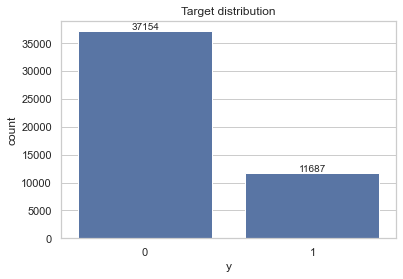

In [18]:
# For classification targets (binary/multiclass)
y = df['y']
print("Target type:", y.dtype)
display(class_balance(y))

ax = sns.countplot(x=y, order=y.value_counts().index)
for container in ax.containers:
    ax.bar_label(container, fmt="%d")
plt.title("Target distribution")
plt.show()

## 3.3 Feature typing and cardinality

### Why?

Separating numeric vs categorical and checking cardinality supports decisions on encoding, scaling, and leakage risks, consistent with course notes on attributes.

In [19]:
# Identify basic types
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numeric cols:", len(numeric_cols))
print("Categorical cols:", len(categorical_cols))

# Cardinality overview
card = (df[categorical_cols]
        .nunique(dropna=False)
        .sort_values(ascending=False)
        .to_frame("n_unique"))
display(card.head(20))


Numeric cols: 7
Categorical cols: 8


,n_unique
native-country,42
education,16
occupation,15
workclass,9
marital-status,7
relationship,6
race,5
sex,2


## 3.4 Missingness Patterns

### Why?
- Missing value extent and patterns determine imputation strategies.

,% missing
occupation,5.75
workclass,5.73
native-country,1.75
age,0.00
fnlwgt,0.00
education,0.00
education-num,0.00
marital-status,0.00
relationship,0.00
race,0.00


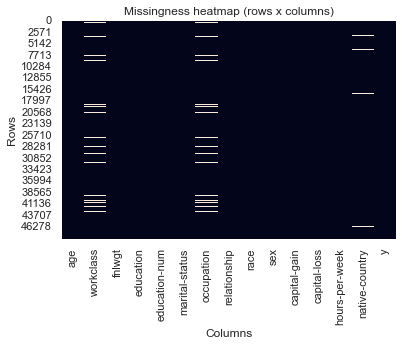

In [20]:
# Percent missing per column
mis = df.isna().mean().mul(100).round(2).sort_values(ascending=False)
display(mis.to_frame("% missing").head(20))

# Heatmap for missingness structure
sns.heatmap(df.isna(), cbar=False)
plt.title("Missingness heatmap (rows x columns)")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()


## 3.5 Numeric feature distributions and outliers

### Why?

- Histograms or boxplots show if data is lopsided or has extreme values. This helps decide how to normalize and pick robust models, as discussed in the course.

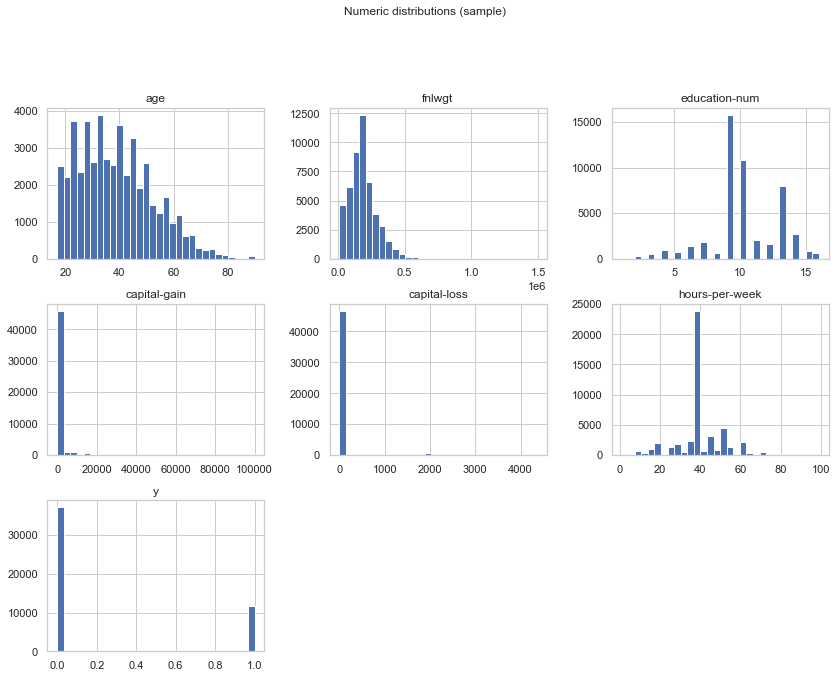

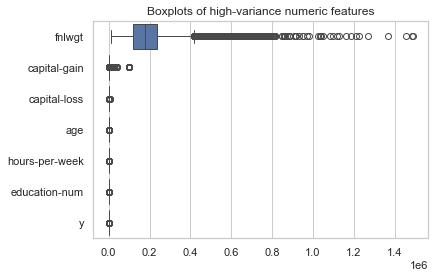

In [21]:
# Histograms
num_sample = numeric_cols[:12]  # limit grid size if many columns
df[num_sample].hist(bins=30, figsize=(14, 10))
plt.suptitle("Numeric distributions (sample)", y=1.02)
plt.show()

# Boxplots for top-variance features
top_var = (df[numeric_cols].var().sort_values(ascending=False).head(8).index.tolist())
sns.boxplot(data=df[top_var], orient="h")
plt.title("Boxplots of high-variance numeric features")
plt.show()

## 3.6 Categorical feature frequencies

### Why?

High/low frequency categories affect one‑hot sparsity and smoothing; checking dominant levels helps plan rare-category handling.

In [22]:
# Top categories per categorical feature
def top_counts(s, k=10):
    return (s.value_counts(dropna=False).head(k)
            .to_frame("count")
            .assign(percent=lambda d: (d["count"]/len(s)*100).round(2)))

for c in categorical_cols[:6]:  # sample a subset for brevity
    print(f"\n{c} (unique={df[c].nunique(dropna=False)})")
    display(top_counts(df[c], k=10))



workclass (unique=9)


,count,percent
workclass,,
Private,33905,69.42
Self-emp-not-inc,3862,7.91
Local-gov,3136,6.42
NaN,2799,5.73
State-gov,1981,4.06
Self-emp-inc,1695,3.47
Federal-gov,1432,2.93
Without-pay,21,0.04
Never-worked,10,0.02



education (unique=16)


,count,percent
education,,
HS-grad,15784,32.32
Some-college,10878,22.27
Bachelors,8025,16.43
Masters,2657,5.44
Assoc-voc,2061,4.22
11th,1811,3.71
Assoc-acdm,1601,3.28
10th,1389,2.84
7th-8th,955,1.96



marital-status (unique=7)


,count,percent
marital-status,,
Married-civ-spouse,22379,45.82
Never-married,16116,33.00
Divorced,6633,13.58
Separated,1530,3.13
Widowed,1518,3.11
Married-spouse-absent,628,1.29
Married-AF-spouse,37,0.08



occupation (unique=15)


,count,percent
occupation,,
Prof-specialty,6172,12.64
Craft-repair,6112,12.51
Exec-managerial,6086,12.46
Adm-clerical,5611,11.49
Sales,5504,11.27
Other-service,4923,10.08
Machine-op-inspct,3021,6.19
NaN,2809,5.75
Transport-moving,2355,4.82



relationship (unique=6)


,count,percent
relationship,,
Husband,19716,40.37
Not-in-family,12583,25.76
Own-child,7580,15.52
Unmarried,5125,10.49
Wife,2331,4.77
Other-relative,1506,3.08



race (unique=5)


,count,percent
race,,
White,41762,85.51
Black,4684,9.59
Asian-Pac-Islander,1519,3.11
Amer-Indian-Eskimo,470,0.96
Other,406,0.83


## 3.7 Correlation analysis (numeric)

### Why?

- Correlation heatmaps expose redundancy and linear relationships; this informs feature selection and regularization decisions as per feature selection lecture.

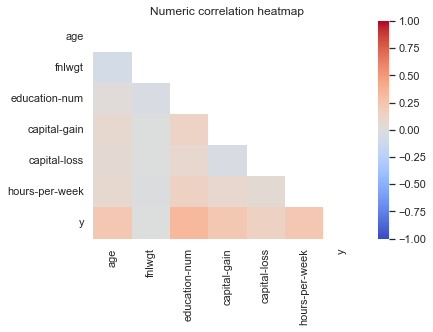

,feat1,feat2,corr


In [23]:
# Pearson correlation among numeric features
corr = df[numeric_cols].corr(numeric_only=True)
# Focus on strongest correlations
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Numeric correlation heatmap")
plt.show()

# List pairs with high |corr|
thr = 0.8
high_pairs = []
for i, a in enumerate(numeric_cols):
    for b in numeric_cols[i+1:]:
        r = corr.loc[a, b]
        if pd.notna(r) and abs(r) >= thr:
            high_pairs.append((a, b, r))
pd.DataFrame(high_pairs, columns=["feat1","feat2","corr"]).sort_values("corr", ascending=False)


## 3.8 Target relationships: numeric vs target

### Why?

- Comparing distributions across classes reveals separability and potential nonlinearity; helpful to decide on transformations and model family.

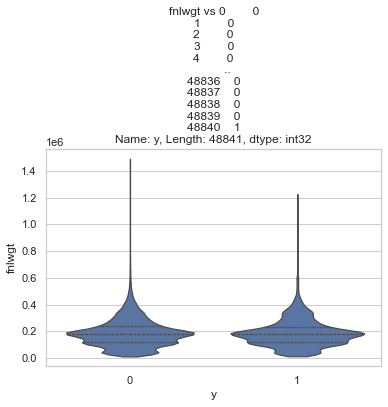

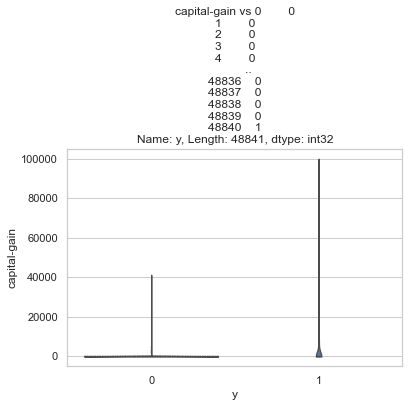

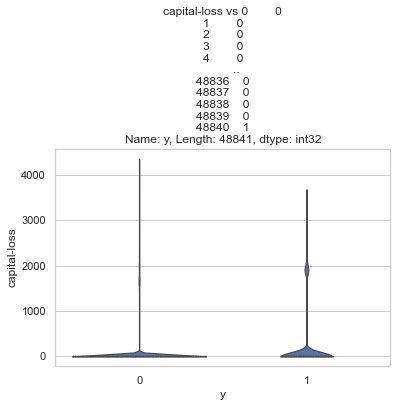

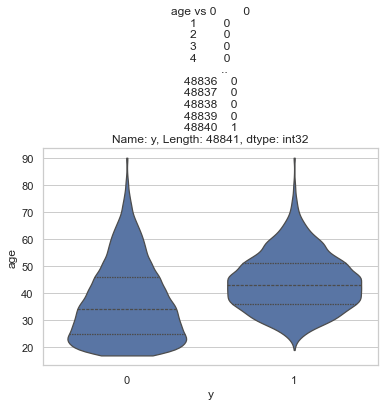

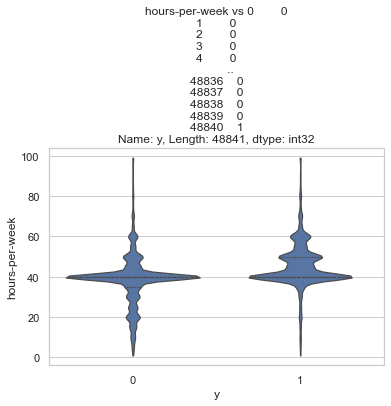

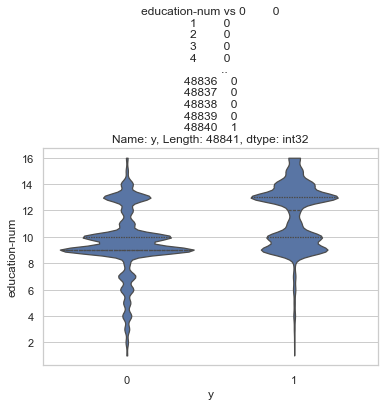

,feature,r_pb,p_value
6,y,1.000000,0.000000e+00
2,education-num,0.332605,0.000000e+00
0,age,0.230361,0.000000e+00
5,hours-per-week,0.227687,0.000000e+00
3,capital-gain,0.223012,0.000000e+00
4,capital-loss,0.147553,8.763144e-236
1,fnlwgt,-0.006335,1.615193e-01


In [24]:
# Boxen/violin plots for a few informative numerics against target
num_for_plots = df[numeric_cols].var().sort_values(ascending=False).head(6).index.tolist()
for c in num_for_plots:
    sns.violinplot(x=y, y=c, data=df, cut=0, inner="quartile")
    plt.title(f"{c} vs {y}")
    plt.show()

# Point-biserial correlation (binary target) if applicable
if y.nunique() == 2:
    from scipy.stats import pointbiserialr
    res = []
    y_bin = pd.Categorical(y).codes
    for c in numeric_cols:
        s = df[c]
        # Use boolean indexing instead of .loc
        non_missing_mask = ~s.isna()
        s_filtered = s[non_missing_mask]
        y_bin_filtered = y_bin[non_missing_mask]

        r, p = pointbiserialr(y_bin_filtered, s_filtered)
        res.append((c, r, p))
    display(pd.DataFrame(res, columns=["feature","r_pb","p_value"])
            .sort_values("r_pb", key=lambda s: s.abs(), ascending=False).head(10))

## 3.9 Target relationships: categorical vs target

### Why?

- Looking at categories helps figure out which ones are linked to the target, guiding choices for encoding and combining rare groups.


workclass (unique=9)


,count,rate
workclass,,
Private,33905,0.217873
Self-emp-not-inc,3862,0.278871
Local-gov,3136,0.295599
State-gov,1981,0.267542
Self-emp-inc,1695,0.553392
Federal-gov,1432,0.391760
Without-pay,21,0.095238
Never-worked,10,0.000000


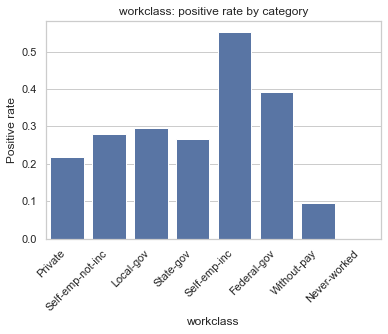


education (unique=16)


,count,rate
education,,
HS-grad,15784,0.158578
Some-college,10878,0.189649
Bachelors,8025,0.412835
Masters,2657,0.549116
Assoc-voc,2061,0.253275
11th,1811,0.050801
Assoc-acdm,1601,0.257964
10th,1389,0.062635
7th-8th,955,0.064921


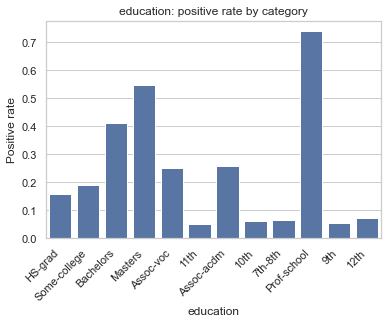


marital-status (unique=7)


,count,rate
marital-status,,
Married-civ-spouse,22379,0.446133
Never-married,16116,0.045483
Divorced,6633,0.101161
Separated,1530,0.064706
Widowed,1518,0.084321
Married-spouse-absent,628,0.092357
Married-AF-spouse,37,0.378378


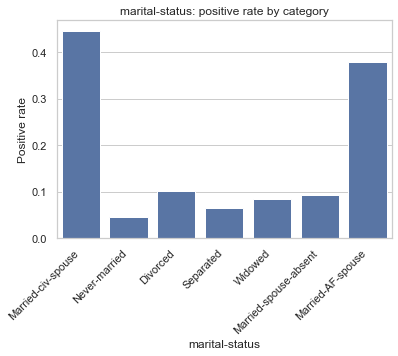


occupation (unique=15)


,count,rate
occupation,,
Prof-specialty,6172,0.451069
Craft-repair,6112,0.226276
Exec-managerial,6086,0.477818
Adm-clerical,5611,0.136874
Sales,5504,0.267987
Other-service,4923,0.041438
Machine-op-inspct,3021,0.123138
Transport-moving,2355,0.204246
Handlers-cleaners,2072,0.066602


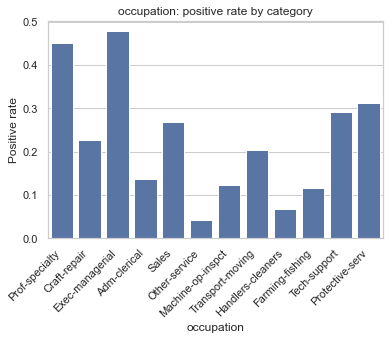


relationship (unique=6)


,count,rate
relationship,,
Husband,19716,0.448671
Not-in-family,12583,0.101407
Own-child,7580,0.014644
Unmarried,5125,0.060293
Wife,2331,0.468897
Other-relative,1506,0.034529


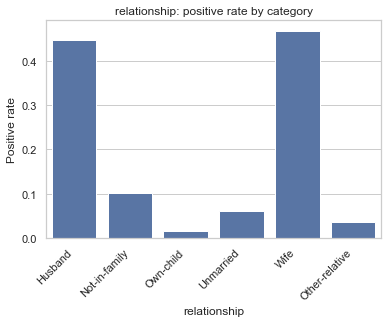


race (unique=5)


,count,rate
race,,
White,41762,0.253987
Black,4684,0.120837
Asian-Pac-Islander,1519,0.269256
Amer-Indian-Eskimo,470,0.117021
Other,406,0.123153


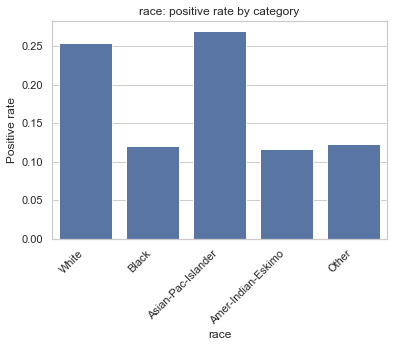

In [25]:
# Target rate per category for top few categorical variables
def target_rate_by_cat(df, cat, target):
    # Create a temporary DataFrame with the categorical column and the target Series
    temp_df = df[[cat]].copy()
    temp_df["target_col"] = target

    # Group by the categorical column and aggregate on the temporary target column
    tab = (temp_df.groupby(cat)["target_col"]
           .agg(count='size', rate='mean') # Corrected named aggregations format for a single Series
          )
    return tab.sort_values("count", ascending=False).head(12)

for c in categorical_cols[:6]:
    print(f"\n{c} (unique={df[c].nunique(dropna=False)})") # Added unique count for clarity
    category_rates = target_rate_by_cat(df, c, y)
    display(category_rates)
    # Bar plot of rate (binary target assumed; otherwise show proportion of a chosen class)
    if y.nunique() == 2:
        # Use the calculated rates directly for plotting
        sns.barplot(x=category_rates.index, y=category_rates['rate'])
        plt.xticks(rotation=45, ha="right")
        plt.title(f"{c}: positive rate by category")
        plt.ylabel("Positive rate")
        plt.show()

## 3.10 Feature redundancy check (example: education vs education-num)

### Why?

- Demonstrate a concrete overlap test between a text category and its numeric rank; motivates later ablations while keeping EDA grounded.

In [26]:
if ("education" in df.columns) and ("education-num" in df.columns):
    ed_map = df[["education","education-num"]].dropna()
    corr_codes = ed_map["education-num"].corr(ed_map["education"].astype("category").cat.codes)
    print("Education vs education-num corr (codes):", round(corr_codes, 3))


Education vs education-num corr (codes): 0.36


## 3.11 What to carry on forward for Preprocessing/Modeling

- Findings from the analysis are used to guide preprocessing decisions: which columns require imputation, which numeric features necessitate scaling or robust scaling due to outliers, and which categorical features with high cardinality should be handled using techniques like one-hot encoding. This aligns with the guidance provided in the lectures on data cleaning and evaluation.

In [27]:
eda_summary = {
    "n_rows": int(df.shape[0]),
    "n_cols": int(df.shape[1]),
    "n_numeric": len(numeric_cols),
    "n_categorical": len(categorical_cols),
    "missing_cols_over_20pct": mis[mis >= 20].index.tolist(),
    "high_corr_pairs_abs_ge_0.8": [(a,b,float(r)) for a,b,r in high_pairs],
    "skewed_numeric_top": (df[numeric_cols].skew().sort_values(ascending=False).head(10).round(2).to_dict())
}
eda_summary

{'n_rows': 48841,
 'n_cols': 15,
 'n_numeric': 7,
 'n_categorical': 8,
 'missing_cols_over_20pct': [],
 'high_corr_pairs_abs_ge_0.8': [],
 'skewed_numeric_top': {'capital-gain': 11.89,
  'capital-loss': 4.57,
  'fnlwgt': 1.44,
  'y': 1.22,
  'age': 0.56,
  'hours-per-week': 0.24,
  'education-num': -0.32}}

# 4. Feature Engineering - Feature Selection and Feature Extraction